# Part-of-Speech Tagging using Feedforward Networks

Author: Pierre Nugues

A part-of-speech tagger using feed-forward networks and trained on a corpus following the Universal Dependencies format. Here we use the English Web Treebank:
https://github.com/UniversalDependencies/UD_English-EWT/tree/master.

## Python Headers

### The Modules

In [1]:
import sys
import os
from sklearn.feature_extraction import DictVectorizer
import time
from keras import models
from keras.layers import LSTM, Bidirectional, SimpleRNN, Dense, Embedding
import sys
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import load_model
import math
import matplotlib.pyplot as plt

### Some Parameters

In [2]:
OPTIMIZER = 'rmsprop'
SCALER = True
SIMPLE_MODEL = True
BATCH_SIZE = 128
EPOCHS = 4
MINI_CORPUS = False

## Preprocessing

### Loading the Corpus

In [3]:
def load_ud_en_ewt():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/ud-treebanks-v2.7/UD_English-EWT/'
    train_file = BASE_DIR + 'en_ewt-ud-train.conllu'
    dev_file = BASE_DIR + 'en_ewt-ud-dev.conllu'
    test_file = BASE_DIR + 'en_ewt-ud-test.conllu'
    column_names = ['ID', 'FORM', 'LEMMA', 'UPOS', 'XPOS', 
                    'FEATS', 'HEAD', 'DEPREL', 'HEAD', 'DEPS', 'MISC']
    column_names = list(map(str.lower, column_names))
    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

def load_conll2009_pos():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/conll2009/en/'
    train_file = BASE_DIR + 'CoNLL2009-ST-English-train-pos.txt'
    dev_file = BASE_DIR + 'CoNLL2009-ST-English-development-pos.txt'
    test_file = BASE_DIR + 'CoNLL2009-ST-test-words-pos.txt'
    # test2_file = 'simple_pos_test.txt'

    column_names = ['id', 'form', 'lemma', 'plemma', 'pos', 'ppos']

    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

# train_sentences, dev_sentences, test_sentences, column_names = \
# load_conll2009_pos()
train_sentences, dev_sentences, test_sentences, column_names =\
load_ud_en_ewt()
train_sentences[:350]

'# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000\n# sent_id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001\n# newpar id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001\n# text = Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town o'

### Converting the Corpus in a Dictionary
We follow the fit-transform pattern of sklearn

In [4]:
import regex as re

class Token(dict):
    pass

class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        rows = [row for row in rows if row[0] != '#']
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [5]:
conll_dict = CoNLLDictorizer(column_names, col_sep='\t')

train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

if MINI_CORPUS:
    train_dict = train_dict[:len(train_dict) // 5]
print('First sentence, train:', train_dict[0])

First sentence, train: [{'id': '1', 'form': 'Al', 'lemma': 'Al', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '0:root', 'deprel': 'root', 'deps': 'SpaceAfter=No'}, {'id': '2', 'form': '-', 'lemma': '-', 'upos': 'PUNCT', 'xpos': 'HYPH', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': 'SpaceAfter=No'}, {'id': '3', 'form': 'Zaman', 'lemma': 'Zaman', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '1:flat', 'deprel': 'flat', 'deps': '_'}, {'id': '4', 'form': ':', 'lemma': ':', 'upos': 'PUNCT', 'xpos': ':', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': '_'}, {'id': '5', 'form': 'American', 'lemma': 'american', 'upos': 'ADJ', 'xpos': 'JJ', 'feats': 'Degree=Pos', 'head': '6:amod', 'deprel': 'amod', 'deps': '_'}, {'id': '6', 'form': 'forces', 'lemma': 'force', 'upos': 'NOUN', 'xpos': 'NNS', 'feats': 'Number=Plur', 'head': '7:nsubj', 'deprel': 'nsubj', 'deps': '_'}, {'id': '7', 'form': 'killed', 'lemma': 'kill', 'upos': 'VERB', 'xpos'

### Extracting the Context and Dictorizing it
We extract windows of five words surrounding the word

In [6]:
class ContextDictorizer():
    """
    Extract contexts of words in a sequence
    Contexts are of w_size to the left and to the right
    Builds an X matrix in the form of a dictionary
    and possibly extracts the output, y, if not in the test step
    If the test_step is True, returns y = []
    """

    def __init__(self, input='form', output='upos', w_size=2, tolower=True):
        self.BOS_symbol = '__BOS__'
        self.EOS_symbol = '__EOS__'
        self.input = input
        self.output = output
        self.w_size = w_size
        self.tolower = tolower
        # This was not correct as the names were not sorted
        # self.feature_names = [input + '_' + str(i)
        #                     for i in range(-w_size, w_size + 1)]
        # To be sure the names are ordered
        zeros = math.ceil(math.log10(2 * w_size + 1))
        self.feature_names = [input + '_' + str(i).zfill(zeros) for 
                              i in range(2 * w_size + 1)]

    def fit(self, sentences):
        """
        Build the padding rows
        :param sentences:
        :return:
        """
        self.column_names = sentences[0][0].keys()
        start = [self.BOS_symbol] * len(self.column_names)
        end = [self.EOS_symbol] * len(self.column_names)
        start_token = Token(dict(zip(self.column_names, start)))
        end_token = Token(dict(zip(self.column_names, end)))
        self.start_rows = [start_token] * self.w_size
        self.end_rows = [end_token] * self.w_size

    def transform(self, sentences, training_step=True):
        X_corpus = []
        y_corpus = []
        for sentence in sentences:
            X, y = self._transform_sentence(sentence, training_step)
            X_corpus += X
            if training_step:
                y_corpus += y
        return X_corpus, y_corpus

    def fit_transform(self, sentences):
        self.fit(sentences)
        return self.transform(sentences)

    def _transform_sentence(self, sentence, training_step=True):
        # We extract y
        if training_step:
            y = [row[self.output] for row in sentence]
        else:
            y = None

        # We pad the sentence
        sentence = self.start_rows + sentence + self.end_rows

        # We extract the features
        X = list()
        for i in range(len(sentence) - 2 * self.w_size):
            # x is a row of X
            x = list()
            # The words in lower case
            for j in range(2 * self.w_size + 1):
                if self.tolower:
                    x.append(sentence[i + j][self.input].lower())
                else:
                    x.append(sentence[i + j][self.input])
            # We represent the feature vector as a dictionary
            X.append(dict(zip(self.feature_names, x)))
        return X, y

    def print_example(self, sentences, id=1968):
        """
        :param corpus:
        :param id:
        :return:
        """
        # We print the features to check they match Table 8.1 in my book (second edition)
        # We use the training step extraction with the dynamic features
        Xs, ys = self._transform_sentence(sentences[id])
        print('X for sentence #', id, Xs)
        print('y for sentence #', id, ys)

### Running the Feature Extraction

In [7]:
context_dictorizer = ContextDictorizer()
context_dictorizer.fit(train_dict)
X_dict, y_cat = context_dictorizer.transform(train_dict)
X_dict_val, y_cat_val = context_dictorizer.transform(dev_dict)

In [8]:
context_dictorizer.print_example(train_dict)

X for sentence # 1968 [{'form_0': '__bos__', 'form_1': '__bos__', 'form_2': 'do', 'form_3': 'we', 'form_4': 'intend'}, {'form_0': '__bos__', 'form_1': 'do', 'form_2': 'we', 'form_3': 'intend', 'form_4': 'to'}, {'form_0': 'do', 'form_1': 'we', 'form_2': 'intend', 'form_3': 'to', 'form_4': 'reference'}, {'form_0': 'we', 'form_1': 'intend', 'form_2': 'to', 'form_3': 'reference', 'form_4': 'a'}, {'form_0': 'intend', 'form_1': 'to', 'form_2': 'reference', 'form_3': 'a', 'form_4': 'particular'}, {'form_0': 'to', 'form_1': 'reference', 'form_2': 'a', 'form_3': 'particular', 'form_4': 'manufacturer'}, {'form_0': 'reference', 'form_1': 'a', 'form_2': 'particular', 'form_3': 'manufacturer', 'form_4': ','}, {'form_0': 'a', 'form_1': 'particular', 'form_2': 'manufacturer', 'form_3': ',', 'form_4': 'or'}, {'form_0': 'particular', 'form_1': 'manufacturer', 'form_2': ',', 'form_3': 'or', 'form_4': 'should'}, {'form_0': 'manufacturer', 'form_1': ',', 'form_2': 'or', 'form_3': 'should', 'form_4': 'this

### Vectorizing the $\mathbf{X}$ Matrix

In [9]:
# We transform the X symbols into numbers
dict_vectorizer = DictVectorizer()
X_num = dict_vectorizer.fit_transform(X_dict)
X_num_val = dict_vectorizer.transform(X_dict_val)

if SCALER:
    # We standardize X_num
    scaler = StandardScaler(with_mean=False)
    X = scaler.fit_transform(X_num)
    X_val = scaler.transform(X_num_val)
else:
    X = X_num
    X_val = X_num_val
print(X.shape)
#X[0, :100].toarray()

(207053, 81317)


### Vectorizing $\mathbf{y}$

The POS and the number of different POS

In [10]:
pos_list = sorted(set(y_cat))
NB_CLASSES = len(pos_list) + 1
pos_list

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X',
 '_']

We build a part-of-speech index. We keep 0 for unknown symbols in the test set

In [11]:
idx_pos = dict(enumerate(pos_list, start=1))
pos_idx = {v: k for k, v in idx_pos.items()}
print(idx_pos)
pos_idx

{1: 'ADJ', 2: 'ADP', 3: 'ADV', 4: 'AUX', 5: 'CCONJ', 6: 'DET', 7: 'INTJ', 8: 'NOUN', 9: 'NUM', 10: 'PART', 11: 'PRON', 12: 'PROPN', 13: 'PUNCT', 14: 'SCONJ', 15: 'SYM', 16: 'VERB', 17: 'X', 18: '_'}


{'ADJ': 1,
 'ADP': 2,
 'ADV': 3,
 'AUX': 4,
 'CCONJ': 5,
 'DET': 6,
 'INTJ': 7,
 'NOUN': 8,
 'NUM': 9,
 'PART': 10,
 'PRON': 11,
 'PROPN': 12,
 'PUNCT': 13,
 'SCONJ': 14,
 'SYM': 15,
 'VERB': 16,
 'X': 17,
 '_': 18}

We encode $\mathbf{y}$. We use one symbol for unknown parts of speech in the test set

In [12]:
y = np.array([pos_idx[i] for i in y_cat])
y_val = np.array([pos_idx[i] for i in y_cat_val])
print(y_cat[:10])
y[:10]

['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN']


array([12, 13, 12, 13,  1,  8, 16, 12, 12, 12])

## The Tagger
   With `sparse_categorical_crossentropy`, we do not need to vectorize $\mathbf{y}$ with `to_categorical`

In [13]:
if SIMPLE_MODEL:
    model = models.Sequential([Dense(NB_CLASSES,
                                     input_dim=X.shape[1],
                                     activation='softmax')])
else:
    model = models.Sequential([
        Dense(NB_CLASSES * 2,
              input_dim=X.shape[1],
              activation='relu'),
        Dropout(0.2),
        Dense(NB_CLASSES, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 19)                1545042   
Total params: 1,545,042
Trainable params: 1,545,042
Non-trainable params: 0
_________________________________________________________________


### Fitting the Model

In [14]:
np.random.seed(0)

start_time = time.perf_counter()
history = model.fit(X, y, epochs=EPOCHS, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)
# model.save('out.model')
print('Time:', (time.perf_counter() - start_time) / 60)

Epoch 1/4
1618/1618 [==============================] - 15s 9ms/step - loss: 0.7973 - accuracy: 0.8015 - val_loss: 0.4812 - val_accuracy: 0.8881
Epoch 2/4
1618/1618 [==============================] - 14s 9ms/step - loss: 0.1915 - accuracy: 0.9537 - val_loss: 0.5252 - val_accuracy: 0.8974
Epoch 3/4
1618/1618 [==============================] - 13s 8ms/step - loss: 0.1409 - accuracy: 0.9702 - val_loss: 0.5666 - val_accuracy: 0.8987
Epoch 4/4
1618/1618 [==============================] - 13s 8ms/step - loss: 0.1198 - accuracy: 0.9767 - val_loss: 0.6000 - val_accuracy: 0.9006
Time: 0.9542282091000001


In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

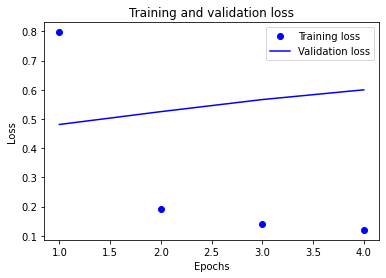

In [16]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

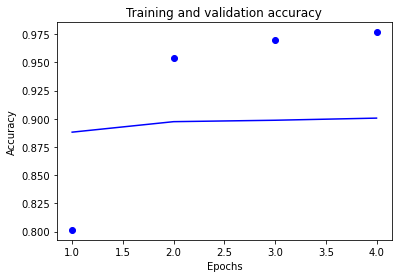

In [17]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Formatting the Test Set

In [18]:
X_test_dict, y_test_cat = context_dictorizer.transform(test_dict)
# We transform the symbols into numbers
X_test_num = dict_vectorizer.transform(X_test_dict)
if SCALER:
    # We standardize X_num
    X_test = scaler.transform(X_test_num)
else:
    X_test = X_test_num
print(y_test_cat[:5])
y_test = np.array([pos_idx.get(i, 0) for i in y_test_cat])
print(y_test[:5])
print(X_test.shape)
X_test[0, :100].toarray()

['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP']
[11 14 12 16  2]
(25429, 81317)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

### Predicting a Value

In [19]:
print(model.predict(X_test[0, :]))
print(idx_pos[np.argmax(model.predict(X_test[0, :]))])
idx_pos[y_test[0]]

[[3.08117909e-09 9.30500299e-09 3.12786987e-08 1.39407828e-08
  8.90962255e-08 4.26859572e-07 2.29218407e-04 2.12668670e-06
  5.31509954e-07 1.06590704e-07 2.74913065e-10 9.99721825e-01
  4.54457911e-08 2.88631998e-08 3.04548848e-07 4.73652676e-07
  1.01571530e-07 4.46138911e-05 1.25050912e-08]]
PRON


'PRON'

### Testing the Model

In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Optimizer', OPTIMIZER, 'Scaler', SCALER, 'Epochs', EPOCHS, 'Batch size', 
      BATCH_SIZE, 'Simple model', SIMPLE_MODEL, 'Mini corpus', MINI_CORPUS)
print('Loss:', test_loss)
print('Accuracy:', test_acc)

795/795 [==============================] - 0s 497us/step - loss: 0.5302 - accuracy: 0.9082
Optimizer rmsprop Scaler True Epochs 4 Batch size 128 Simple model True Mini corpus False
Loss: 0.5301786661148071
Accuracy: 0.9082150459289551


About 90.68 for the simple model and 90.56 for the second one

## Prediction of parts of speech

In [21]:
def predict_sentence(sentence, dict_vect, model, idx_pos):
    column_names = ['id', 'form']
    sentence = list(enumerate(sentence.lower().split(), start=1))
    conll_cols = ''
    for tuple in sentence:
        conll_cols += str(tuple[0]) + '\t' + tuple[1] + '\n'
    # print(conll_cols)

    conll_dict = CoNLLDictorizer(column_names, col_sep='\t')
    sent_dict = conll_dict.transform(conll_cols)
    # print('Sentence:', sent_dict[0])

    context_dictorizer = ContextDictorizer()
    context_dictorizer.fit(sent_dict)
    X_dict, y = context_dictorizer.transform(sent_dict, 
                                             training_step=False)
    # print('Sentence, padded:', X_dict)
    # print('POS, y:', y)
    
    X_num = dict_vect.transform(X_dict)
    if SCALER:
    # We standardize X_num
        X = scaler.transform(X_num)
    else:
        X = X_num

    # print(X)
    y_prob = model.predict(X)
    y_pred = y_prob.argmax(axis=-1)
    y_pred_cat = [idx_pos[i] for i in y_pred]
    return y_pred_cat

In [22]:
sentences = ["That round table might collapse .",
                 "The man can learn well .",
                 "The man can swim .",
                 "The man can simwo ."]
for sentence in sentences:
    y_test_pred_cat = predict_sentence(sentence.lower(), 
                                       dict_vectorizer,
                                       model,
                                       idx_pos)
    print(sentence)
    print(y_test_pred_cat)

That round table might collapse .
['DET', 'DET', 'NOUN', 'AUX', 'NOUN', 'PUNCT']
The man can learn well .
['DET', 'NOUN', 'AUX', 'VERB', 'INTJ', 'PUNCT']
The man can swim .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
The man can simwo .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
